# NVIDIA AI Foundation Endpoints 

> [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/) give users easy access to NVIDIA hosted API endpoints for NVIDIA AI Foundation Models like Mixtral 8x7B, Llama 2, Stable Diffusion, etc. These models, hosted on the [NVIDIA API catalog](https://build.nvidia.com/), are optimized, tested, and hosted on the NVIDIA AI platform, making them fast and easy to evaluate, further customize, and seamlessly run at peak performance on any accelerated stack.
> 
> With [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/), you can get quick results from a fully accelerated stack running on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/). Once customized, these models can be deployed anywhere with enterprise-grade security, stability, and support using [NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/).
> 
> These models can be easily accessed via the [`langchain-nvidia-ai-endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) package, as shown below.

This example goes over how to use LangChain to interact with the supported [NVIDIA Retrieval QA Embedding Model](https://build.nvidia.com/nvidia/embed-qa-4) for [retrieval-augmented generation](https://developer.nvidia.com/blog/build-enterprise-retrieval-augmented-generation-apps-with-nvidia-retrieval-qa-embedding-model/) via the `NVIDIAEmbeddings` class.

For more information on accessing the chat models through this api, check out the [ChatNVIDIA](https://python.langchain.com/docs/integrations/chat/nvidia_ai_endpoints/) documentation.

## Installation

In [1]:
%pip install --upgrade --quiet  langchain-nvidia-ai-endpoints

Note: you may need to restart the kernel to use updated packages.


## Setup

**To get started:**

1. Create a free account with [NVIDIA](https://build.nvidia.com/), which hosts NVIDIA AI Foundation models

2. Select the `Retrieval` tab, then select your model of choice

3. Under `Input` select the `Python` tab, and click `Get API Key`. Then click `Generate Key`.

4. Copy and save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [2]:
import getpass
import os

# del os.environ['NVIDIA_API_KEY']  ## delete key and reset
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

NVAPI Key (starts with nvapi-):  ········


We should be able to see an embedding model among that list which can be used in conjunction with an LLM for effective RAG solutions. We can interface with this model pretty easily with the help of the `NVIDIAEmbeddings` model.

## Initialization

When initializing an embedding model you can select a model by passing it, e.g. `ai-embed-qa-4` below, or use the default by not passing any arguments.

In [3]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="ai-embed-qa-4")

This model is a fine-tuned E5-large model which supports the expected `Embeddings` methods including:

- `embed_query`: Generate query embedding for a query sample.

- `embed_documents`: Generate passage embeddings for a list of documents which you would like to search over.

- `aembed_quey`/`embed_documents`: Asynchronous versions of the above.

### **Similarity**

The following is a quick test of the similarity for these data points:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Documents:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

### Embedding Runtimes

In [4]:
print("\nSequential Embedding: ")
q_embeddings = [
    embedder.embed_query("What's the weather like in Komchatka?"),
    embedder.embed_query("What kinds of food is Italy known for?"),
    embedder.embed_query("What's my name? I bet you don't remember..."),
    embedder.embed_query("What's the point of life anyways?"),
    embedder.embed_query("The point of life is to have fun :D"),
]
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Sequential Embedding: 
Shape: (5, 1024)


### Document Embedding

In [5]:
print("\nBatch Document Embedding: ")
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Batch Document Embedding: 
Shape: (5, 1024)


Now that we've generated our embeddings, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task:

In [6]:
%pip install --upgrade --quiet  matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


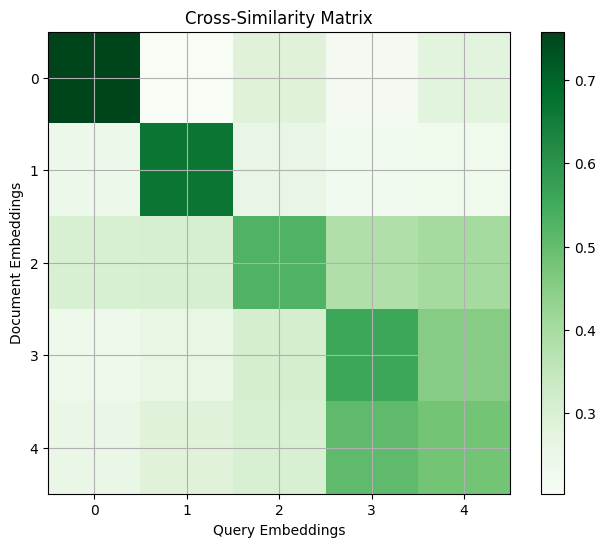

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix between q_embeddings and d_embeddings
cross_similarity_matrix = cosine_similarity(
    np.array(q_embeddings),
    np.array(d_embeddings),
)

# Plotting the cross-similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")
plt.colorbar()
plt.title("Cross-Similarity Matrix")
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.grid(True)
plt.show()

As a reminder, the queries and documents sent to our system were:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Documents:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

## Truncation

Embedding models typically have a fixed context window that determines the maximum number of input tokens that can be embedded. This limit could be a hard limit, equal to the model's maximum input token length, or an effective limit, beyond which the accuracy of the embedding decreases.

Since models operate on tokens and applications usually work with text, it can be challenging for an application to ensure that its input stays within the model's token limits. By default, an exception is thrown if the input is too large.

To assist with this, NVIDIA's NIMs (API Catalog or local) provide a `truncate` parameter that truncates the input on the server side if it's too large.

The `truncate` parameter has three options:
 - "NONE": The default option. An exception is thrown if the input is too large.
 - "START": The server truncates the input from the start (left), discarding tokens as necessary.
 - "END": The server truncates the input from the end (right), discarding tokens as necessary.

In [8]:
long_text = "AI is amazing, amazing is " * 100

In [9]:
strict_embedder = NVIDIAEmbeddings()
try:
    strict_embedder.embed_query(long_text)
except Exception as e:
    print("Error:", e)

Error: [400] Bad Request
Inference error
RequestID: 52ffd96b-2160-4870-8e7f-c6858bf5af63


In [10]:
truncating_embedder = NVIDIAEmbeddings(truncate="END")
truncating_embedder.embed_query(long_text)[:5]

[-0.008758544921875,
 0.0009446144104003906,
 -0.035064697265625,
 0.0254058837890625,
 0.00414276123046875]

## RAG Retrieval:

The following is a repurposing of the initial example of the [LangChain Expression Language Retrieval Cookbook entry](
https://python.langchain.com/docs/expression_language/cookbook/retrieval), but executed with the AI Foundation Models' [Mixtral 8x7B Instruct](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/mixtral-8x7b) and [NVIDIA Retrieval QA Embedding](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/nvolve-40k) models available in their playground environments. The subsequent examples in the cookbook also run as expected, and we encourage you to explore with these options.

**TIP:** We would recommend using Mixtral for internal reasoning (i.e. instruction following for data extraction, tool selection, etc.) and Llama-Chat for a single final "wrap-up by making a simple response that works for this user based on the history and context" response.

In [ ]:
%pip install --upgrade --quiet  langchain faiss-cpu tiktoken

from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_nvidia_ai_endpoints import ChatNVIDIA

In [ ]:
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"],
    embedding=NVIDIAEmbeddings(model="ai-embed-qa-4"),
)
retriever = vectorstore.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

model = ChatNVIDIA(model="ai-mixtral-8x7b-instruct")

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("where did harrison work?")

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer using information solely based on the following context:\n<Documents>\n{context}\n</Documents>"
            "\nSpeak only in the following language: {language}",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "where did harrison work", "language": "italian"})